In [1]:
import numpy as np
import pandas as pd

# pd.set_option('display.height', 1000)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("max_colwidth", 200)
from IPython.core.display import HTML, display

display(HTML("<style>.container { width:100% !important; }</style>"))


def df_stats(df):
    from tabulate import tabulate

    print("\n***** Shape: ", df.shape, " *****\n")

    columns_list = df.columns.values.tolist()
    isnull_list = df.isnull().sum().values.tolist()
    isunique_list = df.nunique().values.tolist()
    dtypes_list = df.dtypes.tolist()

    list_stat_val = list(zip(columns_list, isnull_list, isunique_list, dtypes_list))
    df_stat_val = pd.DataFrame(list_stat_val, columns=["Name", "Null", "Unique", "Dtypes"])
    print(tabulate(df_stat_val, headers="keys", tablefmt="psql"))
    return df.head()

/tmp/ipykernel_96567/1374276192.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [2]:
df_dataset = pd.read_csv("data/reports/reports_sampled_no_conclusion.csv", sep='α')

/tmp/ipykernel_96567/1062137522.py:1: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  df_dataset = pd.read_csv("data/reports/reports_sampled_no_conclusion.csv", sep='α')


In [4]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1) Dictionary for vessel substrings
labels_to_vessel_names = {
    "lad_stenosis": "left anterior descending (lad)",
    "dist_lad_stenosis": "distal segment of the left anterior descending (lad)",
    "mid_lad_stenosis": "mid segment of the left anterior descending (lad)",
    "lcx_stenosis": "left circumflex (lcx)",
    "dist_lcx_stenosis": "distal branch of the left circumflex (lcx)",
    "leftmain_stenosis": "left main coronary artery (lmca)",
    "prox_rca_stenosis": "proximal right coronary artery (rca)",
    "mid_rca_stenosis": "mid portion of the right coronary artery (rca)",
    "dist_rca_stenosis": "distal portion of the right coronary artery (rca)",
    "posterolateral_stenosis": "posterolateral branch",
    "pda_stenosis": "posterior descending artery (pda)",
}


def parse_report_to_numeric_stenoses(report_text, labels_map):
    parsed_dict = {lbl: None for lbl in labels_map.keys()}
    parsed_dict["coronary_dominance"] = None

    sentences = report_text.split(".")
    # Regex capturing e.g. "~70" or "(40.0" if "stenosis" is in the line
    stenosis_regex = re.compile(r"(?:~|\()?(\d+(?:\.\d+)?)")

    for sentence in sentences:
        line = sentence.strip()
        if not line:
            continue

        lower_line = line.lower()

        # Check dominance
        if "the coronary circulation is" in lower_line:
            if "right dominant" in lower_line:
                parsed_dict["coronary_dominance"] = "right"
            elif "left dominant" in lower_line:
                parsed_dict["coronary_dominance"] = "left"
            elif "co dominant" in lower_line or "codominant" in lower_line:
                parsed_dict["coronary_dominance"] = "co"

        # Attempt to find numeric
        match = stenosis_regex.search(line)
        if match and "stenosis" in lower_line:
            numeric_value = float(match.group(1))  # e.g. "70"
        else:
            if "free of" in lower_line and "stenosis" in lower_line:
                numeric_value = 0.0
            else:
                numeric_value = None

        if numeric_value is not None:
            # Loose matching by removing whitespace
            line_no_space = "".join(ch.lower() for ch in line if not ch.isspace())
            for lbl, vessel_substring in labels_map.items():
                vs_no_space = "".join(ch.lower() for ch in vessel_substring if not ch.isspace())
                if vs_no_space in line_no_space:
                    parsed_dict[lbl] = numeric_value

    return parsed_dict


def compute_predicted_stenoses(row, unique_texts_map, labels_map, topk=5):
    aggregated = {lbl: [] for lbl in labels_map.keys()}

    for k in range(1, topk + 1):
        col = f"predicted_idx_{k}"
        if col not in row:
            continue

        idx_val = row[col]
        if pd.isna(idx_val):
            continue

        idx_val = int(idx_val)
        if idx_val not in unique_texts_map:
            continue

        text = unique_texts_map[idx_val]
        parsed = parse_report_to_numeric_stenoses(text, labels_map)
        for lbl, val in parsed.items():
            if lbl == "coronary_dominance":
                continue
            if val is not None:
                aggregated[lbl].append(val)

    results = {}
    for lbl, vals in aggregated.items():
        if len(vals) > 0:
            results[lbl] = sum(vals) / len(vals)
        else:
            results[lbl] = None

    return results


def reverse_engineer_stenosis_predictions(predictions_csv_path, unique_texts_csv_path,
                                         labels_map, topk=5):
    df_pred = pd.read_csv(predictions_csv_path)
    df_texts = pd.read_csv(unique_texts_csv_path)
    unique_texts_map = dict(zip(df_texts["Index"], df_texts["Text"]))

    all_rows = []
    for _, row in df_pred.iterrows():
        row_stenoses = compute_predicted_stenoses(row, unique_texts_map, labels_map, topk)
        all_rows.append(row_stenoses)

    df_stenoses = pd.DataFrame(all_rows)

    # rename => predicted_X
    rename_map = {}
    for col in df_stenoses.columns:
        rename_map[col] = f"predicted_{col}"

    df_stenoses = df_stenoses.rename(columns=rename_map)

    return pd.concat([df_pred.reset_index(drop=True), df_stenoses.reset_index(drop=True)], axis=1)




# The merged_df and the plot are your final outputs

Mean Absolute Error for each vessel:
  lad_stenosis: MAE = 27.34
  dist_lad_stenosis: MAE = 8.96
  mid_lad_stenosis: MAE = 29.34
  lcx_stenosis: MAE = 20.67
  dist_lcx_stenosis: MAE = 18.69
  leftmain_stenosis: MAE = 13.56
  prox_rca_stenosis: MAE = 23.46
  mid_rca_stenosis: MAE = 22.41
  dist_rca_stenosis: MAE = 17.21
  posterolateral_stenosis: MAE = 10.85
  pda_stenosis: MAE = 15.67

Average MAE across all vessels: 18.93
Average correlation across all vessels: 0.22


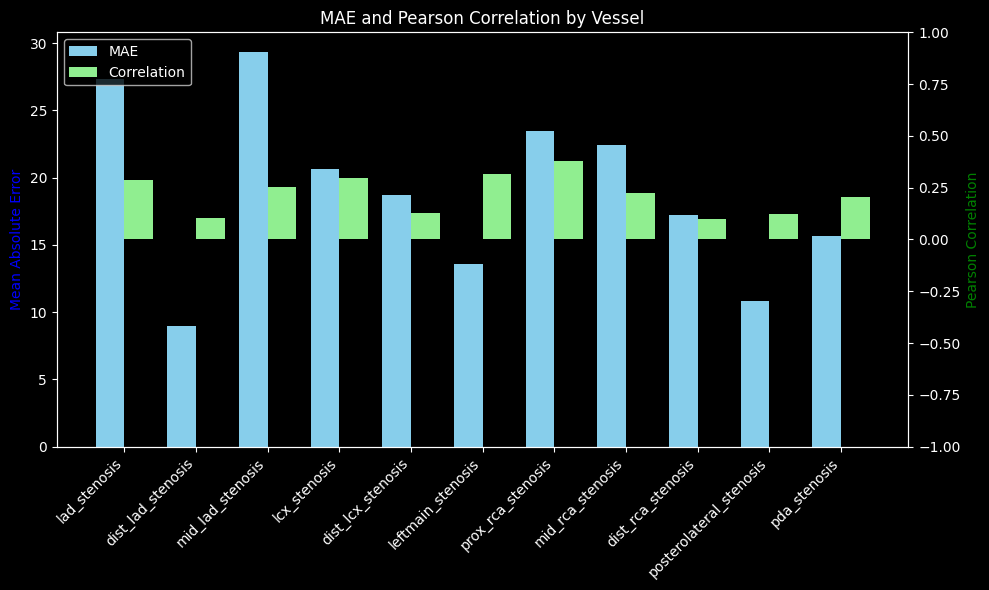

In [10]:
def plot_vessel_metrics(df_dataset, predictions_csv, unique_texts_csv, labels_to_vessel_names, topk=5):
    """
    Generate and plot vessel metrics from predictions and ground truth data.
    
    Args:
        df_dataset: DataFrame containing ground truth data with vessel stenosis columns
        predictions_csv: Path to CSV file containing model predictions
        unique_texts_csv: Path to CSV file containing unique text samples
        labels_to_vessel_names: Dictionary mapping label names to vessel names
        topk: Number of top predictions to consider (default=5)
    """
    # 1) Generate predictions with predicted_* columns
    df_predictions = reverse_engineer_stenosis_predictions(
        predictions_csv,
        unique_texts_csv,
        labels_to_vessel_names,
        topk=topk,
    )

    # 2) Merge with df_dataset on "FileName"
    merged_df = pd.merge(df_predictions, df_dataset, on="FileName", how="left")

    # 3) Compute MAE for each vessel
    vessel_labels = [
        "lad_stenosis",
        "dist_lad_stenosis", 
        "mid_lad_stenosis",
        "lcx_stenosis",
        "dist_lcx_stenosis",
        "leftmain_stenosis",
        "prox_rca_stenosis",
        "mid_rca_stenosis",
        "dist_rca_stenosis",
        "posterolateral_stenosis",
        "pda_stenosis",
    ]

    mae_values = {}
    corr_values = {}

    print("Mean Absolute Error for each vessel:")
    for lbl in vessel_labels:
        pred_col = f"predicted_{lbl}"
        if pred_col not in merged_df.columns or lbl not in merged_df.columns:
            continue

        # absolute error column
        merged_df[f"abs_error_{lbl}"] = (merged_df[pred_col] - merged_df[lbl]).abs()

        mae = merged_df[f"abs_error_{lbl}"].mean(skipna=True)
        mae_values[lbl] = mae
        print(f"  {lbl}: MAE = {mae:.2f}")

        # Pearson correlation (between predicted and actual)
        # we dropna to avoid issues
        valid_rows = merged_df[[lbl, pred_col]].dropna()
        if len(valid_rows) > 1:
            corr = valid_rows[lbl].corr(valid_rows[pred_col], method="pearson")
        else:
            corr = np.nan
        corr_values[lbl] = corr

    # Calculate averages
    avg_mae = np.mean(list(mae_values.values()))
    avg_corr = np.mean(list(corr_values.values()))
    print(f"\nAverage MAE across all vessels: {avg_mae:.2f}")
    print(f"Average correlation across all vessels: {avg_corr:.2f}")

    # 4) Show a quick bar chart of MAE and correlation
    vessels_with_data = [v for v in vessel_labels if v in mae_values]
    mae_list = [mae_values[v] for v in vessels_with_data]
    corr_list = [corr_values[v] for v in vessels_with_data]

    x_positions = np.arange(len(vessels_with_data))
    width = 0.4

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar for MAE
    bar1 = ax1.bar(x_positions - width/2, mae_list, width, label="MAE", color="skyblue")
    ax1.set_ylabel("Mean Absolute Error", color="blue")
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(vessels_with_data, rotation=45, ha="right")

    # We'll create a second axis for correlation
    ax2 = ax1.twinx()
    bar2 = ax2.bar(x_positions + width/2, corr_list, width, label="Correlation", color="lightgreen")
    ax2.set_ylabel("Pearson Correlation", color="green")
    ax2.set_ylim(-1, 1)  # correlation range

    # Combine legends
    bars = [bar1, bar2]
    labels = [b.get_label() for b in bars]
    ax1.legend(bars, labels, loc="upper left")

    plt.title("MAE and Pearson Correlation by Vessel")
    plt.tight_layout()
    plt.show()

    return merged_df, mae_values, corr_values

### Example usage ###
# Suppose you already have a df_dataset with the true columns (like "lad_stenosis"),
# filtered to 'val' split:
# df_dataset = df_dataset[df_dataset["Split"] == "val"]

predictions_csv = "/volume/DeepCORO_CLIP/outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b12_f16_RAdam_lr5.899071161042893e-05_20250104-201129_u5x8nym4/val_epoch0.csv"
unique_texts_csv = "/volume/DeepCORO_CLIP/outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b12_f16_RAdam_lr5.899071161042893e-05_20250104-201129_u5x8nym4/unique_val_texts.csv"

merged_df, mae_values, corr_values = plot_vessel_metrics(
    df_dataset,
    predictions_csv,
    unique_texts_csv,
    labels_to_vessel_names,
    topk=5
)

Mean Absolute Error for each vessel:
  lad_stenosis: MAE = 21.54
  dist_lad_stenosis: MAE = 6.54
  mid_lad_stenosis: MAE = 20.48
  lcx_stenosis: MAE = 20.96
  dist_lcx_stenosis: MAE = 11.92
  leftmain_stenosis: MAE = 20.19
  prox_rca_stenosis: MAE = 30.29
  mid_rca_stenosis: MAE = 25.38
  dist_rca_stenosis: MAE = 6.92
  posterolateral_stenosis: MAE = 0.77
  pda_stenosis: MAE = 3.08

Average MAE across all vessels: 15.28
Average correlation across all vessels: nan


/root/miniforge3/envs/pytorch/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/root/miniforge3/envs/pytorch/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/root/miniforge3/envs/pytorch/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/root/miniforge3/envs/pytorch/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


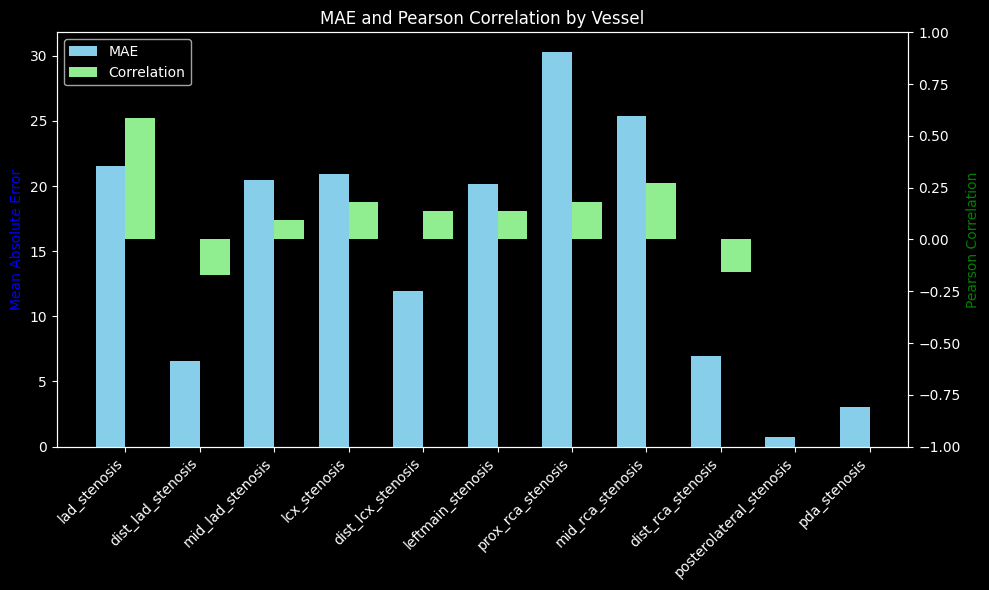

In [11]:

predictions_csv = "/volume/DeepCORO_CLIP/outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b12_f16_RAdam_lr0.0001_20250104-190301_be3qyp8d/val_epoch9.csv"
unique_texts_csv = "/volume/DeepCORO_CLIP/outputs/deepCORO_CLIP/DeepCORO_Clip_Sweep_Learnable_Temp_Full_mvit_b12_f16_RAdam_lr0.0001_20250104-190301_be3qyp8d/unique_val_texts.csv"

merged_df, mae_values, corr_values = plot_vessel_metrics(
    df_dataset,
    predictions_csv,
    unique_texts_csv,
    labels_to_vessel_names,
    topk=5
)